# Vanishing/Exploding Gradients Problem

## Glorot and He Initialization

In [4]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.shape

torch.Size([10, 40])

In [5]:
layer.weight.data[0] 

tensor([-0.0179, -0.0445, -0.1269,  0.0311, -0.0592,  0.0924, -0.0679,  0.0885,
        -0.1484, -0.0157,  0.0093, -0.1164, -0.1053,  0.1270, -0.0780,  0.1365,
         0.1200, -0.1364, -0.1179,  0.1206, -0.0699,  0.0390,  0.0276,  0.1558,
        -0.1311,  0.1100, -0.0495,  0.1154,  0.1360,  0.0588, -0.0222,  0.0445,
        -0.0056, -0.0184, -0.0211,  0.1520,  0.0521,  0.1084,  0.1011,  0.1383])

In [6]:
layer.weight.data *= 6**0.5  # He init

In [7]:
layer.weight.data[0]

tensor([-0.0438, -0.1090, -0.3109,  0.0761, -0.1450,  0.2264, -0.1664,  0.2167,
        -0.3636, -0.0385,  0.0228, -0.2852, -0.2580,  0.3111, -0.1910,  0.3343,
         0.2939, -0.3342, -0.2887,  0.2955, -0.1713,  0.0956,  0.0675,  0.3817,
        -0.3212,  0.2694, -0.1212,  0.2826,  0.3331,  0.1439, -0.0545,  0.1090,
        -0.0137, -0.0450, -0.0518,  0.3723,  0.1277,  0.2656,  0.2478,  0.3387])

In [8]:
layer.bias.data

tensor([-0.0375,  0.0577, -0.0346,  0.0307, -0.0116,  0.0483,  0.0199,  0.0143,
         0.1153, -0.1121])

In [9]:
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)
model = nn.Sequential(nn.Linear(40, 30), nn.ReLU(), nn.Linear(30, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): ReLU()
)

In [12]:
model = nn.Sequential(nn.Linear(40, 10), nn.LeakyReLU(negative_slope=0.2))  # alpha is negative slope
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Better Activation Functions

### Leaky ReLU

In [15]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

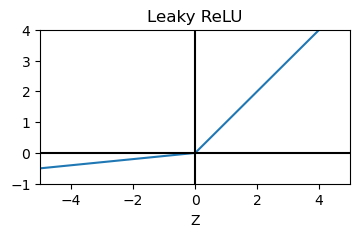

In [16]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5, 5, 200)
plt.figure(figsize=(4,2))
plt.plot(z, leaky_relu(z,0.1) , "-")
plt.plot([-5,5] ,[0,0] , "k-")
plt.plot([0,0] ,[-1,4] , "k-")
plt.axis([-5, 5 , -1, 4])
plt.title("Leaky ReLU")
plt.xlabel("Z")
plt.axis()
plt.show()

In [17]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2,50)).shape

torch.Size([2, 40])

## Batch Normalization

In [19]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        #Running stats (for inference time)
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, X):
        if self.training:
            batch_mean = X.mean(dim=0)
            batch_var = X.var(dim=0, unbiased=False)  # by default sample variance(1/N-1),now population variance(1/N)
            
            #Normalize
            X_hat = (X - batch_mean) / torch.sqrt(batch_var + self.eps)

            #Update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
        else:
            X_hat = (X - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        out = self.gamma * X_hat + self.beta
        return out

In [20]:
torch.manual_seed(42)
model1 = nn.Sequential(
    nn.Flatten(),
    MyBatchNorm(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    MyBatchNorm(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    MyBatchNorm(100),
    nn.Linear(100, 10)
)

In [21]:
dict(model1[1].named_parameters()).keys()

dict_keys(['gamma', 'beta'])

In [22]:
dict(model1[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var'])

In [23]:
torch.manual_seed(42)

model1.train()
x = torch.randn(2,28,28)   
out = model1(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

In [24]:
torch.manual_seed(42)
model2 = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [25]:
dict(model2[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [26]:
torch.manual_seed(42)

model2.train()
x = torch.randn(2,28,28)   
out = model2(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

## Layer Normalization

In [28]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.normalized_shape = normalized_shape

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, X):
        dims = tuple(range(-len(self.normalized_shape),0))
        mean = X.mean(dim=dims, keepdim=True)
        var = X.var(dim=dims, unbiased=False, keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + self.eps)
        return self.gamma * X_hat + self.beta           

In [29]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = MyLayerNorm([100,200])
result1 = layer_norm(inputs)

In [30]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = nn.LayerNorm([100,200])
result2 = layer_norm(inputs)

In [31]:
assert torch.allclose(result1, result2)

In [32]:
layer_norm = MyLayerNorm([32, 4, 100, 200])
result3 = layer_norm(inputs)

In [33]:
layer_norm = nn.LayerNorm([32, 4, 100, 200])
result4 = layer_norm(inputs)
assert torch.allclose(result3, result4)

## Gradient Clipping

### Value Clipping

In [36]:
grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
clip_value = 3.0
grad_value_clipped = torch.clamp(grad, min= -clip_value, max=clip_value)
grad_value_clipped

tensor([ 3., -3.,  2.,  3.])

In [37]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_value_([param], clip_value=3.0)
param.grad

tensor([ 3., -3.,  2.,  3.])

### Norm Clipping

In [39]:
max_norm = 3.0
grad_norm = torch.sqrt(torch.sum(grad**2))
grad_norm

tensor(13.8924)

In [40]:
if grad_norm > max_norm:
    scale = max_norm / grad_norm
    grad_norm_clipped = grad * scale
else:
    grad_norm_clipped = grad

grad_norm_clipped

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])

In [41]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_norm_([param], max_norm=3.0)
param.grad

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])

In [42]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

# Faster Optimizers

In [44]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, criterion, metric, train_loader, valid_loader, n_epochs):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = 0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item()
        )
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
    return history
        

In [45]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'mps'

In [46]:

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader,n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [47]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.04)
history_sgd, acc_sgd = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5718, Train Metric: 0.7951, Valid Metric: 0.8402
Epoch:2/10, Train Loss: 0.4056, Train Metric: 0.8511, Valid Metric: 0.8524
Epoch:3/10, Train Loss: 0.3662, Train Metric: 0.8652, Valid Metric: 0.8572
Epoch:4/10, Train Loss: 0.3416, Train Metric: 0.8745, Valid Metric: 0.8740
Epoch:5/10, Train Loss: 0.3222, Train Metric: 0.8826, Valid Metric: 0.8732
Epoch:6/10, Train Loss: 0.3088, Train Metric: 0.8860, Valid Metric: 0.8720
Epoch:7/10, Train Loss: 0.2954, Train Metric: 0.8895, Valid Metric: 0.8762
Epoch:8/10, Train Loss: 0.2842, Train Metric: 0.8941, Valid Metric: 0.8740
Epoch:9/10, Train Loss: 0.2751, Train Metric: 0.8975, Valid Metric: 0.8728
Epoch:10/10, Train Loss: 0.2652, Train Metric: 0.9013, Valid Metric: 0.8620


In [48]:
acc_sgd

tensor(0.8584, device='mps:0')

## Momentum Optimization

In [50]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
history_momentum, acc_momentum = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.6046, Train Metric: 0.7787, Valid Metric: 0.8088
Epoch:2/10, Train Loss: 0.4719, Train Metric: 0.8318, Valid Metric: 0.8394
Epoch:3/10, Train Loss: 0.4359, Train Metric: 0.8439, Valid Metric: 0.8480
Epoch:4/10, Train Loss: 0.4111, Train Metric: 0.8531, Valid Metric: 0.8488
Epoch:5/10, Train Loss: 0.3938, Train Metric: 0.8603, Valid Metric: 0.8648
Epoch:6/10, Train Loss: 0.3849, Train Metric: 0.8636, Valid Metric: 0.8662
Epoch:7/10, Train Loss: 0.3725, Train Metric: 0.8653, Valid Metric: 0.8622
Epoch:8/10, Train Loss: 0.3708, Train Metric: 0.8682, Valid Metric: 0.8674
Epoch:9/10, Train Loss: 0.3577, Train Metric: 0.8725, Valid Metric: 0.8654
Epoch:10/10, Train Loss: 0.3502, Train Metric: 0.8758, Valid Metric: 0.8666


## Nesterov Accelerated Gradient

In [52]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(),lr=0.05, momentum=0.9, nesterov=True)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5454, Train Metric: 0.8047, Valid Metric: 0.8046
Epoch:2/10, Train Loss: 0.4412, Train Metric: 0.8423, Valid Metric: 0.8442
Epoch:3/10, Train Loss: 0.4073, Train Metric: 0.8555, Valid Metric: 0.8440
Epoch:4/10, Train Loss: 0.3935, Train Metric: 0.8595, Valid Metric: 0.8508
Epoch:5/10, Train Loss: 0.3798, Train Metric: 0.8654, Valid Metric: 0.8572
Epoch:6/10, Train Loss: 0.3709, Train Metric: 0.8683, Valid Metric: 0.8642
Epoch:7/10, Train Loss: 0.3550, Train Metric: 0.8718, Valid Metric: 0.8502
Epoch:8/10, Train Loss: 0.3587, Train Metric: 0.8726, Valid Metric: 0.8616
Epoch:9/10, Train Loss: 0.3458, Train Metric: 0.8759, Valid Metric: 0.8694
Epoch:10/10, Train Loss: 0.3385, Train Metric: 0.8784, Valid Metric: 0.8628


## AdaGrad

In [54]:
model = build_model()
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5717, Train Metric: 0.8067, Valid Metric: 0.8502
Epoch:2/10, Train Loss: 0.3812, Train Metric: 0.8583, Valid Metric: 0.8536
Epoch:3/10, Train Loss: 0.3486, Train Metric: 0.8709, Valid Metric: 0.8658
Epoch:4/10, Train Loss: 0.3282, Train Metric: 0.8785, Valid Metric: 0.8752
Epoch:5/10, Train Loss: 0.3115, Train Metric: 0.8846, Valid Metric: 0.8750
Epoch:6/10, Train Loss: 0.2992, Train Metric: 0.8886, Valid Metric: 0.8768
Epoch:7/10, Train Loss: 0.2879, Train Metric: 0.8923, Valid Metric: 0.8792
Epoch:8/10, Train Loss: 0.2773, Train Metric: 0.8968, Valid Metric: 0.8810
Epoch:9/10, Train Loss: 0.2691, Train Metric: 0.8999, Valid Metric: 0.8856
Epoch:10/10, Train Loss: 0.2602, Train Metric: 0.9033, Valid Metric: 0.8848


## RMSProp

In [56]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.05, alpha=0.9)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 3.1093, Train Metric: 0.3231, Valid Metric: 0.3502
Epoch:2/10, Train Loss: 1.7068, Train Metric: 0.3391, Valid Metric: 0.3386
Epoch:3/10, Train Loss: 1.6363, Train Metric: 0.3483, Valid Metric: 0.3698
Epoch:4/10, Train Loss: 1.6707, Train Metric: 0.3494, Valid Metric: 0.3532
Epoch:5/10, Train Loss: 1.7494, Train Metric: 0.3322, Valid Metric: 0.3466
Epoch:6/10, Train Loss: 1.7111, Train Metric: 0.3401, Valid Metric: 0.3372
Epoch:7/10, Train Loss: 1.6620, Train Metric: 0.3485, Valid Metric: 0.3550
Epoch:8/10, Train Loss: 1.6604, Train Metric: 0.3516, Valid Metric: 0.3544
Epoch:9/10, Train Loss: 1.6564, Train Metric: 0.3485, Valid Metric: 0.3536
Epoch:10/10, Train Loss: 1.6123, Train Metric: 0.3594, Valid Metric: 0.3640


## Adam

In [119]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05, betas=(0.9,0.999))
history_adam, acc_adam = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 1.1077, Train Metric: 0.6148, Valid Metric: 0.5746
Epoch:2/10, Train Loss: 1.2568, Train Metric: 0.5043, Valid Metric: 0.5606
Epoch:3/10, Train Loss: 1.2486, Train Metric: 0.4945, Valid Metric: 0.4464
Epoch:4/10, Train Loss: 1.4849, Train Metric: 0.3476, Valid Metric: 0.2942
Epoch:5/10, Train Loss: 1.3237, Train Metric: 0.4254, Valid Metric: 0.4674
Epoch:6/10, Train Loss: 1.1705, Train Metric: 0.4874, Valid Metric: 0.4998
Epoch:7/10, Train Loss: 1.1935, Train Metric: 0.4837, Valid Metric: 0.5132
Epoch:8/10, Train Loss: 1.2585, Train Metric: 0.4830, Valid Metric: 0.4670
Epoch:9/10, Train Loss: 1.3580, Train Metric: 0.4284, Valid Metric: 0.3682
Epoch:10/10, Train Loss: 1.3989, Train Metric: 0.4082, Valid Metric: 0.4248


## Adamax

In [115]:
model = build_model()
optimizer = torch.optim.Adamax(model.parameters(),lr=0.05, betas=(0.9,0.999))
history_adamax , acc_adamax = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.6353, Train Metric: 0.7917, Valid Metric: 0.8224
Epoch:2/10, Train Loss: 0.4789, Train Metric: 0.8291, Valid Metric: 0.8188
Epoch:3/10, Train Loss: 0.4540, Train Metric: 0.8393, Valid Metric: 0.8474
Epoch:4/10, Train Loss: 0.4290, Train Metric: 0.8471, Valid Metric: 0.8300
Epoch:5/10, Train Loss: 0.4163, Train Metric: 0.8513, Valid Metric: 0.8518
Epoch:6/10, Train Loss: 0.4086, Train Metric: 0.8544, Valid Metric: 0.8548
Epoch:7/10, Train Loss: 0.3976, Train Metric: 0.8585, Valid Metric: 0.8424
Epoch:8/10, Train Loss: 0.3927, Train Metric: 0.8600, Valid Metric: 0.8494
Epoch:9/10, Train Loss: 0.3843, Train Metric: 0.8632, Valid Metric: 0.8580
Epoch:10/10, Train Loss: 0.3791, Train Metric: 0.8669, Valid Metric: 0.8502


## Nadam

In [62]:
model = build_model()
optimizer = torch.optim.NAdam(model.parameters(),lr=0.05, betas=(0.9,0.99))
history_nadam , acc_nadam = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 1.1779, Train Metric: 0.5618, Valid Metric: 0.5968
Epoch:2/10, Train Loss: 1.2334, Train Metric: 0.4652, Valid Metric: 0.4804
Epoch:3/10, Train Loss: 1.2562, Train Metric: 0.4620, Valid Metric: 0.4356
Epoch:4/10, Train Loss: 1.3521, Train Metric: 0.4198, Valid Metric: 0.4214
Epoch:5/10, Train Loss: 1.3316, Train Metric: 0.4295, Valid Metric: 0.4254
Epoch:6/10, Train Loss: 1.3217, Train Metric: 0.4249, Valid Metric: 0.4158
Epoch:7/10, Train Loss: 1.3316, Train Metric: 0.4234, Valid Metric: 0.4364
Epoch:8/10, Train Loss: 1.3274, Train Metric: 0.4269, Valid Metric: 0.4308
Epoch:9/10, Train Loss: 1.3482, Train Metric: 0.4268, Valid Metric: 0.3884
Epoch:10/10, Train Loss: 1.3604, Train Metric: 0.4142, Valid Metric: 0.4344


## AdamW

In [120]:
model = build_model()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.05, betas=(0.9,0.999),
                             weight_decay=1e-5)
history_adamw, acc_adamw = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 1.1911, Train Metric: 0.5746, Valid Metric: 0.3020
Epoch:2/10, Train Loss: 1.5292, Train Metric: 0.3055, Valid Metric: 0.2046
Epoch:3/10, Train Loss: 1.7541, Train Metric: 0.1993, Valid Metric: 0.2044
Epoch:4/10, Train Loss: 2.1530, Train Metric: 0.1304, Valid Metric: 0.0934
Epoch:5/10, Train Loss: 2.3085, Train Metric: 0.1012, Valid Metric: 0.1002
Epoch:6/10, Train Loss: 2.3087, Train Metric: 0.1000, Valid Metric: 0.0994
Epoch:7/10, Train Loss: 2.3091, Train Metric: 0.0977, Valid Metric: 0.0980
Epoch:8/10, Train Loss: 2.3094, Train Metric: 0.0974, Valid Metric: 0.0980
Epoch:9/10, Train Loss: 2.3093, Train Metric: 0.1009, Valid Metric: 0.0994
Epoch:10/10, Train Loss: 2.3094, Train Metric: 0.0973, Valid Metric: 0.1042


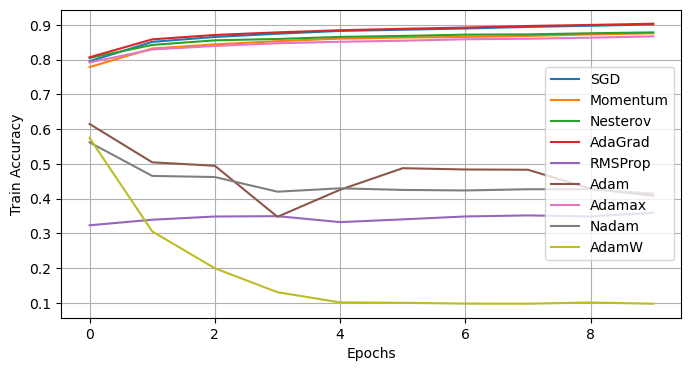

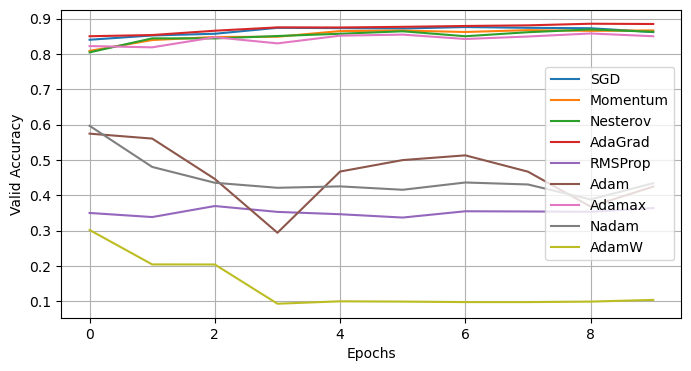

In [123]:
for plot in ("train_metrics","valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw),opt_names.split()):
        plt.plot(history[plot], label=opt_name)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_metrics":"Train Accuracy","valid_metrics":"Valid Accuracy"}[plot])
    plt.legend()
    plt.show()
    

# Learning Rate Scheduling

### Exponential LR

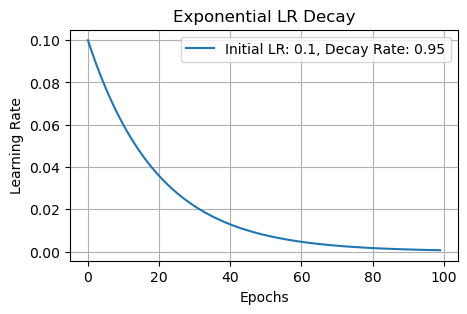

In [177]:
initial_lr = 0.1 
decay_rate = 0.95 
epochs = 100      
epochs_list = np.arange(0, epochs)
lr_decay = initial_lr * decay_rate**epochs_list

plt.figure(figsize=(5, 3))
plt.plot(epochs_list, lr_decay, label=f'Initial LR: {initial_lr}, Decay Rate: {decay_rate}')
plt.title('Exponential LR Decay')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

In [187]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [189]:
def train_with_scheduler(model, optimizer, criterion, metric, train_loader,
                        valid_loader, n_epochs, scheduler):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = 0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        valid_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(valid_metric)
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_metric)
        else:
            scheduler.step()
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def train_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(model, optimizer, xentropy, metric, train_loader,
                                  valid_loader, n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)


In [191]:
history_exp, acc_exp = train_scheduler(model, optimizer, exp_scheduler)

Epoch:1/10, Train Loss: 0.6046, Train Metric: 0.7787, Valid Metric: 0.8088
Learning Rate: 0.04500
Epoch:2/10, Train Loss: 0.4581, Train Metric: 0.8342, Valid Metric: 0.8392
Learning Rate: 0.04050
Epoch:3/10, Train Loss: 0.4123, Train Metric: 0.8511, Valid Metric: 0.8432
Learning Rate: 0.03645
Epoch:4/10, Train Loss: 0.3782, Train Metric: 0.8620, Valid Metric: 0.8498
Learning Rate: 0.03281
Epoch:5/10, Train Loss: 0.3580, Train Metric: 0.8692, Valid Metric: 0.8618
Learning Rate: 0.02952
Epoch:6/10, Train Loss: 0.3411, Train Metric: 0.8749, Valid Metric: 0.8702
Learning Rate: 0.02657
Epoch:7/10, Train Loss: 0.3205, Train Metric: 0.8807, Valid Metric: 0.8716
Learning Rate: 0.02391
Epoch:8/10, Train Loss: 0.3087, Train Metric: 0.8860, Valid Metric: 0.8642
Learning Rate: 0.02152
Epoch:9/10, Train Loss: 0.2955, Train Metric: 0.8897, Valid Metric: 0.8788
Learning Rate: 0.01937
Epoch:10/10, Train Loss: 0.2841, Train Metric: 0.8937, Valid Metric: 0.8790
Learning Rate: 0.01743


### Reduce On Plateau

In [196]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [198]:
history_perf, acc_perf = train_scheduler(model, optimizer, perf_scheduler)

Epoch:1/10, Train Loss: 0.6046, Train Metric: 0.7787, Valid Metric: 0.8088
Learning Rate: 0.05000
Epoch:2/10, Train Loss: 0.4719, Train Metric: 0.8318, Valid Metric: 0.8394
Learning Rate: 0.05000
Epoch:3/10, Train Loss: 0.4359, Train Metric: 0.8439, Valid Metric: 0.8480
Learning Rate: 0.05000
Epoch:4/10, Train Loss: 0.4111, Train Metric: 0.8531, Valid Metric: 0.8488
Learning Rate: 0.05000
Epoch:5/10, Train Loss: 0.3938, Train Metric: 0.8603, Valid Metric: 0.8648
Learning Rate: 0.05000
Epoch:6/10, Train Loss: 0.3849, Train Metric: 0.8636, Valid Metric: 0.8662
Learning Rate: 0.05000
Epoch:7/10, Train Loss: 0.3725, Train Metric: 0.8653, Valid Metric: 0.8622
Learning Rate: 0.05000
Epoch:8/10, Train Loss: 0.3708, Train Metric: 0.8682, Valid Metric: 0.8674
Learning Rate: 0.05000
Epoch:9/10, Train Loss: 0.3577, Train Metric: 0.8725, Valid Metric: 0.8654
Learning Rate: 0.05000
Epoch:10/10, Train Loss: 0.3502, Train Metric: 0.8758, Valid Metric: 0.8666
Learning Rate: 0.05000


### With Warmup

In [201]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3
)

In [203]:
# same as above 
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch,3)/3) * (1.0 - 0.1) + 0.1)


In [211]:
def train_with_warmup(model, optimizer, criterion, metric, train_loader,
                     valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = []
        metric.reset()
        model.train()

        warmup_scheduler.step()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(total_loss))
        history["train_metrics"].append(metric.compute().item())
        valid_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(valid_metric)
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
        if epoch >= 3:
            scheduler.step(valid_metric)

        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                         n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)

    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(model, optimizer, xentropy, metric, train_loader, 
                               valid_loader, n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)


In [213]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler)

Epoch:1/10, Train Loss: 0.4656, Train Metric: 0.8319, Valid Metric: 0.8458
Learning Rate: 0.02000
Epoch:2/10, Train Loss: 0.4653, Train Metric: 0.8345, Valid Metric: 0.8320
Learning Rate: 0.02000
Epoch:3/10, Train Loss: 0.4161, Train Metric: 0.8512, Valid Metric: 0.8470
Learning Rate: 0.02000
Epoch:4/10, Train Loss: 0.3965, Train Metric: 0.8588, Valid Metric: 0.8464
Learning Rate: 0.05000
Epoch:5/10, Train Loss: 0.3848, Train Metric: 0.8624, Valid Metric: 0.8526
Learning Rate: 0.05000
Epoch:6/10, Train Loss: 0.3686, Train Metric: 0.8677, Valid Metric: 0.8616
Learning Rate: 0.05000
Epoch:7/10, Train Loss: 0.3591, Train Metric: 0.8723, Valid Metric: 0.8350
Learning Rate: 0.05000
Epoch:8/10, Train Loss: 0.3502, Train Metric: 0.8741, Valid Metric: 0.8692
Learning Rate: 0.05000
Epoch:9/10, Train Loss: 0.3423, Train Metric: 0.8785, Valid Metric: 0.8658
Learning Rate: 0.05000
Epoch:10/10, Train Loss: 0.3430, Train Metric: 0.8765, Valid Metric: 0.8624
Learning Rate: 0.05000


({'train_losses': [0.46559179742420187,
   0.46528198573913876,
   0.4160864388417407,
   0.396535389259709,
   0.384760552311859,
   0.36861627045726275,
   0.3591259144562979,
   0.3502190231717798,
   0.3423277604555654,
   0.3430107051724435],
  'train_metrics': [0.8318727016448975,
   0.8345272541046143,
   0.8511999845504761,
   0.8587636351585388,
   0.8623636364936829,
   0.867690920829773,
   0.8722727298736572,
   0.8741272687911987,
   0.8785091042518616,
   0.8764908909797668],
  'valid_metrics': [0.84579998254776,
   0.8320000171661377,
   0.847000002861023,
   0.8464000225067139,
   0.8525999784469604,
   0.8615999817848206,
   0.8349999785423279,
   0.8691999912261963,
   0.8658000230789185,
   0.8623999953269958]},
 tensor(0.8539, device='mps:0'))